### Dockless scooters exploration

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import rtree
import re
import os
from fiona.crs import from_epsg
from geopandas.tools import sjoin
import networkx as nx
try:
    import urllib as urllib
except ImportError:
    import urllib3 as urllib
import requests
import zipfile
import io
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
%matplotlib inline

#### Data cleaning has been done in Preprocessing so, we will just read ion the processed data.

In [2]:
dockless = pd.read_csv('../Dockless_data_Austin.csv',infer_datetime_format=True,\
                       parse_dates=['start_time','end_time'],encoding='ascii')

#### Checking how the dataframe looks

In [3]:
dockless.head()

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,modified_date,month,hour,day_of_week,council_district_start,council_district_end,origin_cell_id,destination_cell_id,year,start_latitude,start_longitude,end_latitude,end_longitude
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,scooter,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,12/12/2018 09:36:14 PM,6.0,17.0,5.0,5.0,9.0,13445.0,13916.0,2018.0,30.263,-97.762,30.259,-97.754
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,scooter,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,12/13/2018 03:43:44 PM,11.0,11.0,5.0,9.0,9.0,14556.0,15186.0,2018.0,30.283,-97.745,30.284,-97.737
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,scooter,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,12/13/2018 03:49:54 PM,10.0,15.0,2.0,9.0,9.0,15344.0,15032.0,2018.0,30.285,-97.734,30.291,-97.738
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,scooter,1096.0,0.0,2018-09-02 16:45:00,2018-09-02 17:00:00,12/13/2018 03:53:09 PM,9.0,16.0,0.0,9.0,9.0,14707.0,14081.0,2018.0,30.268,-97.743,30.276,-97.752
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,scooter,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,12/12/2018 10:24:56 PM,9.0,11.0,5.0,3.0,3.0,16114.0,15642.0,2018.0,30.242,-97.721,30.244,-97.729


In [4]:
## Seeing if the columns have appropriate datatypes
dockless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612879 entries, 0 to 2612878
Data columns (total 20 columns):
id                        object
device_id                 object
vehicle_type              object
trip_duration             float64
trip_distance             float64
start_time                datetime64[ns]
end_time                  datetime64[ns]
modified_date             object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
origin_cell_id            float64
destination_cell_id       float64
year                      float64
start_latitude            float64
start_longitude           float64
end_latitude              float64
end_longitude             float64
dtypes: datetime64[ns](2), float64(14), object(4)
memory usage: 398.7+ MB


In [5]:
dockless.shape

(2612879, 20)

In [6]:
len(dockless.id.unique())

2612879

In [7]:
dockless.drop(['vehicle_type','modified_date'],axis=1,inplace=True)

In [8]:
# dockless_sub = dockless[:100000]

In [9]:
dockless.dropna(inplace=True)

In [10]:
# Keeping track of the lost records
dockless.shape

(2612783, 18)

In [11]:
dockless['date'] = dockless.start_time.dt.date

In [12]:
# dockless_sub.dropna(inplace=True)

#### Reading in the shape file for Austin Council Districts

In [13]:
filename_council = [f for f in os.listdir('council_districts/') for ending in ['dbf', 'prj', 'shp', 'shx'] if f.endswith(ending)]
print(filename_council)

['geo_export_a9cbcd82-61df-4e90-b67f-b7649d24806a.shx', 'geo_export_a9cbcd82-61df-4e90-b67f-b7649d24806a.shp', 'geo_export_a9cbcd82-61df-4e90-b67f-b7649d24806a.dbf', 'geo_export_a9cbcd82-61df-4e90-b67f-b7649d24806a.prj']


In [14]:
dbf, prj, shp, shx = [filename for filename in filename_council]
council_districts = gpd.read_file('council_districts/'+shp)

In [15]:
council_districts.head()

,council_di,created_by,date_creat,time_creat,modified_b,date_modif,time_modif,objectid,shape_area,shape_leng,single_mem,geometry
0,http://www.austintexas.gov/department/district-3,meekss,2018-06-14,11:00:25.000,lockwoodg,2016-10-18,13:41:59.000,1.0,5.027911e+08,153982.266647,400378072.0,"(POLYGON ((-97.680452610835 30.267642217703, -..."
1,http://www.austintexas.gov/department/district-4,meekss,2018-06-14,11:00:26.000,lockwoodg,2016-10-18,13:42:05.000,3.0,3.308754e+08,105092.713667,400378084.0,"POLYGON ((-97.70834462297 30.392488241669, -97..."
2,http://www.austintexas.gov/department/district-2,meekss,2018-06-14,11:00:26.000,lockwoodg,2016-10-18,13:41:55.000,2.0,1.290120e+09,689873.424949,400378076.0,"(POLYGON ((-97.718093991782 30.184857710517, -..."
3,http://www.austintexas.gov/department/district-9,meekss,2018-06-14,11:00:26.000,lockwoodg,2016-10-18,13:42:32.000,4.0,3.482170e+08,135780.245550,400378086.0,"POLYGON ((-97.731632625359 30.317929225339, -9..."
4,http://www.austintexas.gov/department/district-5,meekss,2018-06-14,11:00:25.000,meekss,2018-03-30,16:36:17.000,8.0,6.719064e+08,343441.587183,400378068.0,"(POLYGON ((-97.79137132583099 30.093084953282,..."


In [16]:
council_districts['district'] = council_districts.council_di.apply(lambda x:re.sub("\D", "",x))
council_districts.district = council_districts.district.astype('int')

In [17]:
type(council_districts)

geopandas.geodataframe.GeoDataFrame

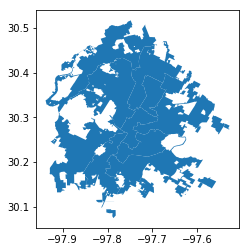

In [18]:
ax = council_districts.plot()

#### Reading in the shape file for Austin Census Tracts

In [19]:
filenames = [f for f in os.listdir('CT_Austin/') for ending in ['dbf', 'prj', 'shp', 'shx'] if f.endswith(ending)]

In [20]:
dbf, prj, shp, shx = [filename for filename in filenames]
ct = gpd.read_file('CT_Austin/'+shp)

In [21]:
ct.head()

,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,SUM_hu_tot,SUM_hu_occ,SUM_hu_vac,SUM_age18p,SUM_age55_,SUM_age65_,SUM_age74_,SUM_OWN_OC,SUM_REN_OC,SUM_AGE_0_,SUM_AGE_5_,SUM_AGE_10,SUM_AGE_15,SUM_AGE_18,SUM_AGE_20,SUM_AGE_25,SUM_AGE_35,SUM_AGE_45,SUM_AGE_46,SUM_AGE50_,SUM_AGE_60,SUM_AGE_55,SUM_AGE60_,SUM_AGE62_,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000101,3611.0,3130.0,39.0,276.0,90.0,9.0,67.0,2076.0,1815.0,261.0,3017.0,356.0,636.0,485.0,1128.0,687.0,238.0,160.0,137.0,59.0,31.0,246.0,704.0,576.0,468.0,0.0,207.0,153.0,203.0,72.0,81.0,38.0,151.0,79.0,103.0,303.0,354.0,77.0,805.0,1010.0,"POLYGON ((3110996.149334418 10094866.83662638,..."
1,000102,2552.0,2311.0,23.0,150.0,42.0,3.0,23.0,1153.0,1081.0,72.0,1985.0,466.0,487.0,234.0,982.0,99.0,119.0,174.0,182.0,92.0,30.0,61.0,173.0,346.0,422.0,0.0,212.0,212.0,254.0,86.0,126.0,70.0,253.0,77.0,66.0,91.0,299.0,18.0,735.0,346.0,"POLYGON ((3108183.235349492 10097092.04712778,..."
2,000203,1546.0,1073.0,87.0,213.0,143.0,5.0,25.0,817.0,735.0,82.0,1492.0,74.0,39.0,14.0,4.0,731.0,20.0,9.0,8.0,17.0,68.0,733.0,385.0,106.0,87.0,0.0,39.0,35.0,39.0,18.0,17.0,8.0,25.0,6.0,6.0,2.0,32.0,281.0,122.0,613.0,"POLYGON ((3117475.629412891 10088913.11716985,..."
3,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,1750.0,1596.0,154.0,2620.0,288.0,153.0,73.0,606.0,990.0,139.0,115.0,84.0,51.0,55.0,611.0,662.0,459.0,392.0,0.0,198.0,118.0,170.0,41.0,77.0,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
4,000205,3394.0,2333.0,110.0,676.0,162.0,24.0,89.0,2153.0,1996.0,157.0,3054.0,272.0,174.0,79.0,546.0,1450.0,126.0,93.0,67.0,54.0,63.0,423.0,1095.0,591.0,436.0,0.0,212.0,102.0,170.0,52.0,50.0,35.0,95.0,30.0,28.0,21.0,212.0,0.0,557.0,1439.0,"POLYGON ((3118490.457187081 10090915.15399349,..."


In [22]:
ct.shape

(350, 42)

In [23]:
ct.to_crs({'init' :'epsg:4326'},inplace=True)

In [24]:
ct.crs

{'init': 'epsg:4326'}

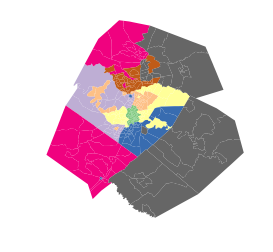

In [25]:
ax = ct.plot(cmap='Accent')
ax.axis('off')
plt.show()

In [26]:
ct = ct[['TRACTCE10','geometry']]

In [27]:
# %%time
# #Combine lat long into a tuple column
# dockless['lonlat'] = list(zip(dockless.start_longitude, dockless.start_latitude))
# #Create Point feature in geometry column
# dockless['geometry'] = dockless.lonlat.apply(lambda x: shapely.geometry.Point(x))
# #Create GeoDataFrame
# dockless_gdf = gpd.GeoDataFrame(dockless)
# #Set CRS
# dockless_gdf.crs = {'init': 'epsg:4326'}
# # dockless_sub_gdf.crs = from_epsg(4326) 

In [28]:
council_districts.crs

{u'init': u'epsg:4326'}

In [29]:
%%time 
## Another way to convert dataframes to geodataframes
dockless_gdf_start = gpd.GeoDataFrame(dockless,geometry=gpd.points_from_xy(dockless.start_longitude, dockless.start_latitude),crs={'init': 'epsg:4326'})
# council_districts = council_districts.to_crs(epsg=4326)

CPU times: user 29.9 s, sys: 1.29 s, total: 31.2 s
Wall time: 31.4 s


In [30]:
dockless_gdf_start.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,origin_cell_id,destination_cell_id,year,start_latitude,start_longitude,end_latitude,end_longitude,date,geometry
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,6.0,17.0,5.0,5.0,9.0,13445.0,13916.0,2018.0,30.263,-97.762,30.259,-97.754,2018-06-29,POINT (-97.762 30.263)
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,11.0,11.0,5.0,9.0,9.0,14556.0,15186.0,2018.0,30.283,-97.745,30.284,-97.737,2018-11-30,POINT (-97.745 30.283)
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,10.0,15.0,2.0,9.0,9.0,15344.0,15032.0,2018.0,30.285,-97.734,30.291,-97.738,2018-10-02,POINT (-97.73399999999999 30.285)
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,1096.0,0.0,2018-09-02 16:45:00,2018-09-02 17:00:00,9.0,16.0,0.0,9.0,9.0,14707.0,14081.0,2018.0,30.268,-97.743,30.276,-97.752,2018-09-02,POINT (-97.74299999999999 30.268)
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,9.0,11.0,5.0,3.0,3.0,16114.0,15642.0,2018.0,30.242,-97.721,30.244,-97.729,2018-09-28,POINT (-97.721 30.242)


In [31]:
to_keep = ['id','device_id','trip_duration','trip_distance','start_time','end_time','geometry','date']
dockless_gdf_start = dockless_gdf_start[to_keep]

In [32]:
ct.crs

{'init': 'epsg:4326'}

In [33]:
%%time
# Aggregate the data on the census tract level based on the start location
dockless_agg_census = gpd.sjoin(dockless_gdf_start,ct,how='right')

CPU times: user 3min 42s, sys: 20.7 s, total: 4min 3s
Wall time: 4min 7s


In [34]:
# %%time
# # Aggregate the data on the council district level based on the start location
# dockless_agg_council = gpd.sjoin(dockless_gdf,council_districts.iloc[:,7:],how='right')

In [35]:
dockless_agg_census.index = dockless_agg_census.index_left
dockless_agg_census.sort_index(inplace=True)
dockless_agg_census.drop(['index_left'],axis=1,inplace=True)
dockless_agg_census.reset_index(drop=True,inplace=True)
dockless_agg_census.TRACTCE10 = dockless_agg_census.TRACTCE10.astype('int')

In [36]:
dockless_agg_census.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,date,TRACTCE10,geometry
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,2018-06-29,1303,POLYGON ((-97.76480699894427 30.24920399997832...
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,2018-11-30,604,POLYGON ((-97.74390399894391 30.28787599997814...
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,2018-10-02,601,POLYGON ((-97.73544999894393 30.28017199997812...
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,1096.0,0.0,2018-09-02 16:45:00,2018-09-02 17:00:00,2018-09-02,1100,POLYGON ((-97.73974099894406 30.27235999997816...
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,2018-09-28,2304,POLYGON ((-97.71424999894428 30.24720399997796...


In [37]:
dockless_agg_census.shape

(2612916, 9)

In [38]:
dockless_agg_census.dropna(inplace=True)

In [39]:
# Keeping count of lost rows(< 300)
dockless_agg_census.shape

(2612783, 9)

In [40]:
# Checking the number of trips that have zero/negative trip duration or distance
dockless_agg_census.loc[(dockless_agg_census.trip_distance<=0) \
                                              | (dockless_agg_census.trip_duration<=0)].shape

(308313, 9)

#### Woah, that's more than 10% of the entire dataset.

In [41]:
# Removing rows with non-positive distance or duration because valid trips cannot have negative distance 
# or duration [unless they were time-travellers;)]
dockless_agg_census_chopped = dockless_agg_census.loc[(dockless_agg_census.trip_distance>0) \
                                              & (dockless_agg_census.trip_duration>0)]

In [42]:
# Keeping track of the lost trips(>300k)
dockless_agg_census_chopped.shape

(2304470, 9)

In [43]:
# dockless_agg_census_chopped.rename({'date':'start_date'},axis=1,inplace=True)
# dockless_agg_census_chopped['end_date'] = dockless_agg_census_chopped.end_time.dt.date
# dockless_agg_census_chopped.start_time = dockless_agg_census_chopped.start_time.dt.time
# dockless_agg_census_chopped.end_time = dockless_agg_census_chopped.end_time.dt.time

In [44]:
dockless_agg_census_chopped.drop('geometry',axis=1,inplace=True)

/anaconda3/envs/nishi/lib/python2.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
dockless_agg_census_chopped.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,date,TRACTCE10
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,2018-06-29,1303
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,2018-11-30,604
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,2018-10-02,601
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,2018-09-28,2304
5,00002f2a-0bcd-4446-bb39-df9fd62be813,d7f470bf-8f4f-4a07-bed7-1f091014920f,1094.0,2631.0,2018-07-22 16:30:00,2018-07-22 16:45:00,2018-07-22,1305


In [46]:
dockless_agg_census_chopped = pd.DataFrame(dockless_agg_census_chopped)

In [47]:
type(dockless_agg_census_chopped)

pandas.core.frame.DataFrame

In [48]:
dockless_agg_census_chopped.describe()

,trip_duration,trip_distance,TRACTCE10
count,2.304470e+06,2.304470e+06,2.304470e+06
mean,6.926883e+02,4.610976e+04,9.905832e+02
std,2.672737e+03,9.201484e+06,2.368821e+03
min,1.000000e+00,1.000000e+00,1.010000e+02
25%,2.410000e+02,5.190000e+02,6.030000e+02
50%,4.080000e+02,1.001000e+03,1.100000e+03
75%,7.900000e+02,1.846000e+03,1.100000e+03
max,1.888695e+06,2.147480e+09,9.800000e+05


In [49]:
dockless_agg_census_chopped.trip_duration.sort_values(ascending=False)[:5]

90609      1888695.0
621304     1824467.0
729683     1192515.0
1044197     966019.0
1334670     937540.0
Name: trip_duration, dtype: float64

In [50]:
dockless_agg_census_chopped.trip_duration.sort_values()[:5]

2401816    1.0
2518626    1.0
2580191    1.0
2550981    1.0
1132406    1.0
Name: trip_duration, dtype: float64

In [51]:
dockless_agg_census_chopped.trip_distance.sort_values(ascending=False)[:5]

820773     2.147480e+09
1398362    2.147471e+09
1432472    2.147463e+09
1222486    2.147434e+09
118335     2.147425e+09
Name: trip_distance, dtype: float64

In [52]:
dockless_agg_census_chopped.trip_distance.sort_values()[:5]

2351713    1.0
2153638    1.0
1703986    1.0
1703989    1.0
2153623    1.0
Name: trip_distance, dtype: float64

#### As seen above, a few trips have durations which last for multiple days and some trips that have distances greater a million kilometers. In contrast, there are trips with only 1 second duration or 1 meter travelled. These would most likely be device malfunctions and not trips. So, we have decided to set a threshold of 10 meters and 10 seconds on the lower side and 40,000 seconds and meters on the higher side. The motivation for choosing 40,000 meters is that dockless scooters can go about 20-25 miles at most on a single charge which comes to about 35 kilometers and so, it is highly unlikely that a trip would last more than 40,000 meters.

In [53]:
dockless_agg_census_chopped.shape

(2304470, 8)

In [54]:
dockless_agg_census_chopped = dockless_agg_census_chopped[(dockless_agg_census_chopped.trip_duration<40000) & \
                            (dockless_agg_census_chopped.trip_duration>10)]
dockless_agg_census_chopped = dockless_agg_census_chopped[(dockless_agg_census_chopped.trip_distance<40000) & \
                            (dockless_agg_census_chopped.trip_distance>10)]

In [55]:
# Keeping a track of lost rows(almost 30K)
dockless_agg_census_chopped.shape

(2272597, 8)

In [56]:
dockless_agg_census_chopped['start_hour'] = dockless_agg_census_chopped.start_time.dt.hour

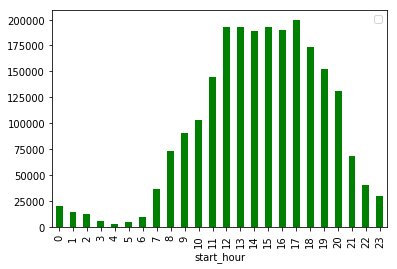

In [57]:
dockless_agg_census_chopped.groupby('start_hour').count()[['id']].\
                        rename({'id':'no_of_trips'},axis=1).plot(kind='bar',color='green')
plt.legend('')
plt.show()

In [58]:
dockless_agg_census_chopped.to_csv('../dockless_agg_census_chopped.csv',index=False)

In [59]:
avg_trip = dockless_agg_census.groupby('TRACTCE10',as_index=False).mean()[['TRACTCE10','trip_duration','trip_distance']]
no_trips = dockless_agg_census.groupby('TRACTCE10',as_index=False).count()[['TRACTCE10','id']]

In [60]:
avg_trip.rename({'trip_duration':'avg_trip_duration','trip_distance':'avg_trip_distance'},axis=1,inplace=True)
no_trips.rename({'id':'number_of_trips'},axis=1,inplace=True)

In [61]:
ct.TRACTCE10 = ct.TRACTCE10.astype('int')

In [62]:
avg_trip_gdf = ct[['TRACTCE10','geometry']].merge(avg_trip,on='TRACTCE10')

In [63]:
avg_trip_gdf.head()

,TRACTCE10,geometry,avg_trip_duration,avg_trip_distance
0,101,POLYGON ((-97.75153299894339 30.33456299997818...,991.852213,1972.654164
1,102,POLYGON ((-97.76028399894329 30.34085899997832...,815.567416,1727.127341
2,203,POLYGON ((-97.73144099894353 30.31778199997807...,721.917622,1782.177393
3,204,POLYGON ((-97.74055599894378 30.29890099997812...,735.049947,1778.210180
4,205,POLYGON ((-97.72807699894349 30.32321999997804...,777.992675,-3299.340764


In [64]:
# council_districts.district = council_districts.district.astype('int')

In [65]:
# avg_trip_gdf = council_districts[['district','shape_area','geometry']].merge(avg_trip,left_on='district',right_on='council_district_start')

In [66]:
# avg_trip_gdf.head()

In [67]:
avg_trip_gdf.avg_trip_duration /= 60

Text(0.5,1,'Average trip duration(in minutes) travelled based on start census tract')

<Figure size 1584x1800 with 0 Axes>

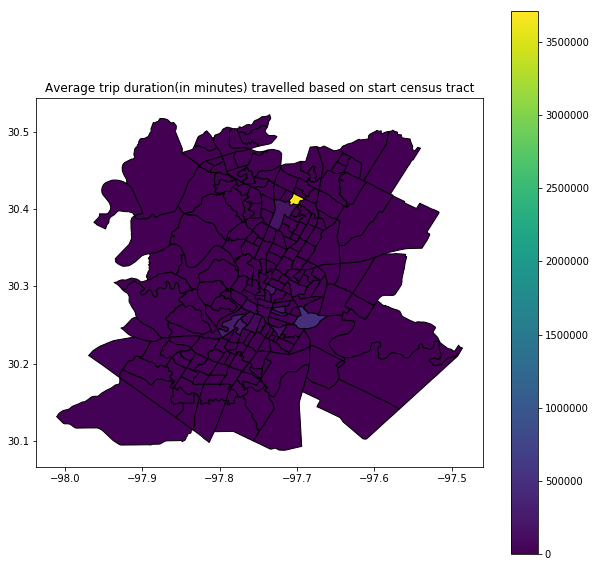

In [68]:
fig = plt.figure(figsize=(22,25))
ax = fig.add_subplot()
avg_trip_gdf.plot(column='avg_trip_distance', cmap='viridis', figsize=(10,10), edgecolor='black', legend=True,
                 ax=ax)
plt.title('Average trip duration(in minutes) travelled based on start census tract')


# ax = fig.add_subplot(2,2,2)
# droppoff_zones.plot(column='dropoffCount', cmap='Blues', figsize=(10,10), edgecolor='black', legend=True, scheme="Quantiles",
#                    ax=ax)
# plt.title('Rides count by drop off zone')

# plt.show()

In [69]:
dockless.council_district_start = dockless.council_district_start.astype('int')
dockless.council_district_end = dockless.council_district_end.astype('int')

In [70]:
dockless.groupby(['council_district_start','council_district_end']).count()[['id']]

id
council_district_start council_district_end         
0                      0                         461
                       1                           7
                       2                          13
                       3                           6
                       4                          12
                       5                          37
                       6                           3
                       7                          16
                       8                          43
                       9                          34
                       10                          5
1                      0                          13
                       1                       79546
                       2                           4
                       3                        7617
                       4                         378
                       5                         519
                       7                          58
                       8                         103
                       9                       71066
                       10                        101
2                      0                          21
                       1                           7
                       2                        3003
                       3                         447
                       4                           2
                       5                         165
                       8                           6
                       9                         159
3                      0                          15
                       1                        8558
                       2                         854
                       3                      138421
                       4                          26
                       5                        2272
                       7                          17
                       8                         218
                       9                       47896
                       10                         67
4                      0                          21
                       1                         421
                       3                          12
                       4                        8564
                       5                           3
                       7                        1052
                       9                        1351
                       10                         28
5                      0                         120
                       1                         430
                       2                         201
...                                              ...
                       7                           9
                       8                        3016
                       9                       25181
                       10                        158
6                      0                          16
                       1                           1
                       6                         336
                       7                          11
                       9                          16
                       10                          6
7                      0                          29
                       1                          64
                       3                           6
                       4                        1259
                       5                           5
                       6                          33
                       7                       28583
                       8                           1
                       9                        1045
                       10                        508
8                      0                          78
                       1                          71
                       2                           5
                      

![Austin_Council_Districts](Austin_council_districts.png)

In [149]:
dock_gpd_plot = dockless_agg_census.loc[dockless_agg_census.index.isin(dockless_agg_census_chopped.index)]

In [32]:
type(dockless.council_district_start[0])

numpy.int64

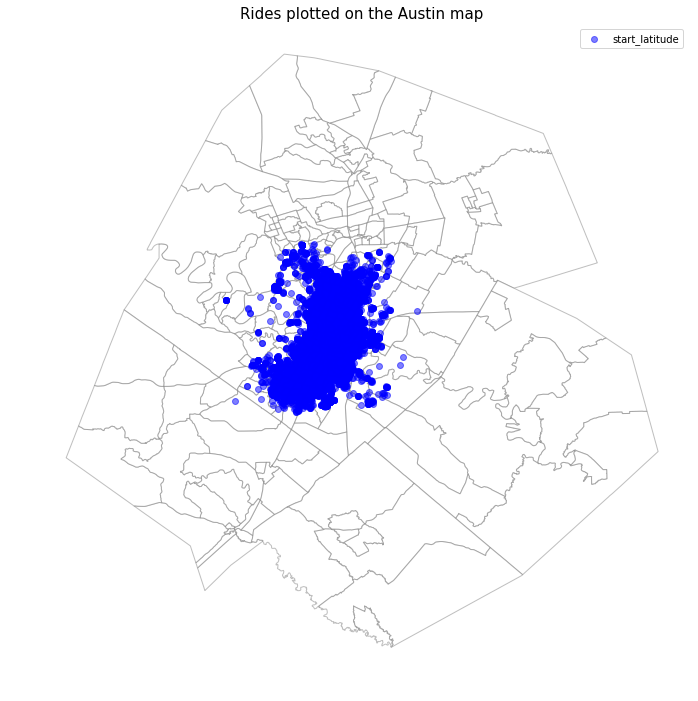

In [74]:
fig, ax = plt.subplots(figsize  = (12, 12))

ax.set_title("Rides plotted on the Austin map", fontsize=15)


ct.plot(ax=ax, legend=True, scheme='Equal_Interval', k=5, color="white", edgecolor='grey', lw=1,alpha=0.5)
# ax.scatter(dockless.start_latitude,dockless.start_longitude,alpha=0.5)
ax.axis('off')
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

plt.scatter(dockless.start_longitude,dockless.start_latitude,c ='blue',alpha=0.5)

#Correct aspect ratio
ax.axes.set_aspect('equal')
plt.legend()
plt.show()

In [ ]:
plt.scatter(dockless.start_longitude,dockless.start_latitude,c=dockless.council_district_start)

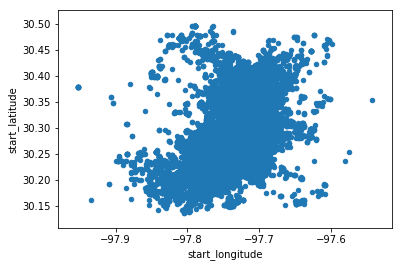

In [18]:
plt.scatter(dockless.start_latitude,dockless.start_longitude,c=dockless,alpha=0.5)

#### So, the number of rides originating in each council district kind of make sense,as district 9 has the most number of rides and it represents the city center.

In [62]:
FG = nx.from_pandas_dataframe(dockless_sub, source='council_district_start', target='council_district_end', edge_attr=True)

In [63]:
FG.nodes()

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [64]:
FG.edges()

[(0.0, 0.0),
 (0.0, 2.0),
 (0.0, 4.0),
 (0.0, 5.0),
 (0.0, 7.0),
 (0.0, 8.0),
 (0.0, 9.0),
 (1.0, 1.0),
 (1.0, 2.0),
 (1.0, 3.0),
 (1.0, 4.0),
 (1.0, 5.0),
 (1.0, 7.0),
 (1.0, 8.0),
 (1.0, 9.0),
 (1.0, 10.0),
 (2.0, 2.0),
 (2.0, 3.0),
 (2.0, 5.0),
 (2.0, 9.0),
 (3.0, 3.0),
 (3.0, 4.0),
 (3.0, 5.0),
 (3.0, 7.0),
 (3.0, 8.0),
 (3.0, 9.0),
 (3.0, 10.0),
 (4.0, 4.0),
 (4.0, 5.0),
 (4.0, 7.0),
 (4.0, 9.0),
 (4.0, 10.0),
 (5.0, 5.0),
 (5.0, 7.0),
 (5.0, 8.0),
 (5.0, 9.0),
 (5.0, 10.0),
 (6.0, 10.0),
 (6.0, 6.0),
 (6.0, 7.0),
 (7.0, 7.0),
 (7.0, 9.0),
 (7.0, 10.0),
 (8.0, 8.0),
 (8.0, 9.0),
 (8.0, 10.0),
 (9.0, 9.0),
 (9.0, 10.0),
 (10.0, 10.0)]

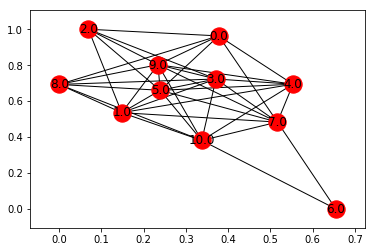

In [66]:
nx.draw_networkx(FG, with_labels=True)

In [ ]:
nx.degree_centrality(FG)

In [77]:
#Combine lat long into a tuple column
dockless_sub['lonlat'] = list(zip(dockless_sub.start_longitude, dockless_sub.start_latitude))
#Create Point feature in geometry column
dockless_sub['geometry'] = dockless_sub.lonlat.apply(lambda x: shapely.geometry.Point(x))
#Create GeoDataFrame
dockless_sub_gdf = gpd.GeoDataFrame(dockless_sub)
#Set CRS
dockless_sub_gdf.crs = from_epsg(4326)

/anaconda3/envs/nishi/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/nishi/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [141]:
min(dockless_sub_gdf.start_time)

Timestamp('2018-04-05 11:30:00')

In [142]:
dockless_sub_gdf.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,origin_cell_id,destination_cell_id,year,start_latitude,start_longitude,end_latitude,end_longitude,lonlat,geometry
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,6.0,17.0,5.0,5.0,9.0,13445.0,13916.0,2018.0,30.263,-97.762,30.259,-97.754,"(-97.762, 30.263)",POINT (-97.762 30.263)
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,11.0,11.0,5.0,9.0,9.0,14556.0,15186.0,2018.0,30.283,-97.745,30.284,-97.737,"(-97.745, 30.283)",POINT (-97.745 30.283)
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,10.0,15.0,2.0,9.0,9.0,15344.0,15032.0,2018.0,30.285,-97.734,30.291,-97.738,"(-97.734, 30.285)",POINT (-97.73399999999999 30.285)
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,1096.0,0.0,2018-09-02 16:45:00,2018-09-02 17:00:00,9.0,16.0,0.0,9.0,9.0,14707.0,14081.0,2018.0,30.268,-97.743,30.276,-97.752,"(-97.743, 30.268)",POINT (-97.74299999999999 30.268)
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,9.0,11.0,5.0,3.0,3.0,16114.0,15642.0,2018.0,30.242,-97.721,30.244,-97.729,"(-97.721, 30.242)",POINT (-97.721 30.242)


In [153]:
len(dockless[dockless['month']==11].device_id.unique())

12362

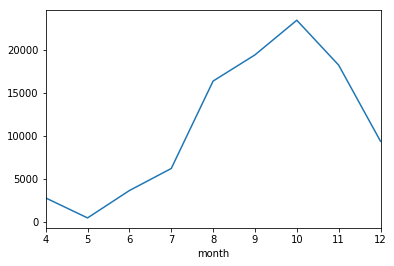

In [139]:
dockless_sub_gdf.groupby('month').count()['id'].plot()

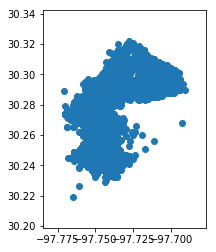

In [80]:
dockless_sub_gdf[dockless_sub_gdf.council_district_start==9].plot()

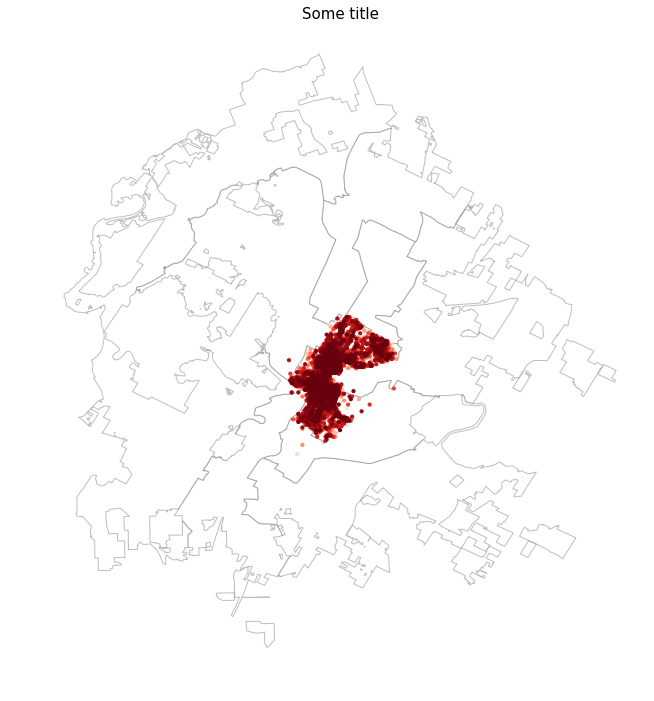

In [158]:
fig, ax = plt.subplots(figsize  = (12, 12))

ax.set_title("Some title", fontsize=15)

council_districts.plot(ax=ax, legend=True, scheme='Equal_Interval', k=5, color="white", edgecolor='grey', lw=1,alpha=0.5)

ax.axis('off')
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

dockless_sub_gdf[dockless_sub_gdf.council_district_start==9].plot(ax=ax, cmap='Reds', markersize=10)

#Correct aspect ratio
ax.axes.set_aspect('equal')

plt.show()

NameError: name 'dockless_sub_gdf' is not defined

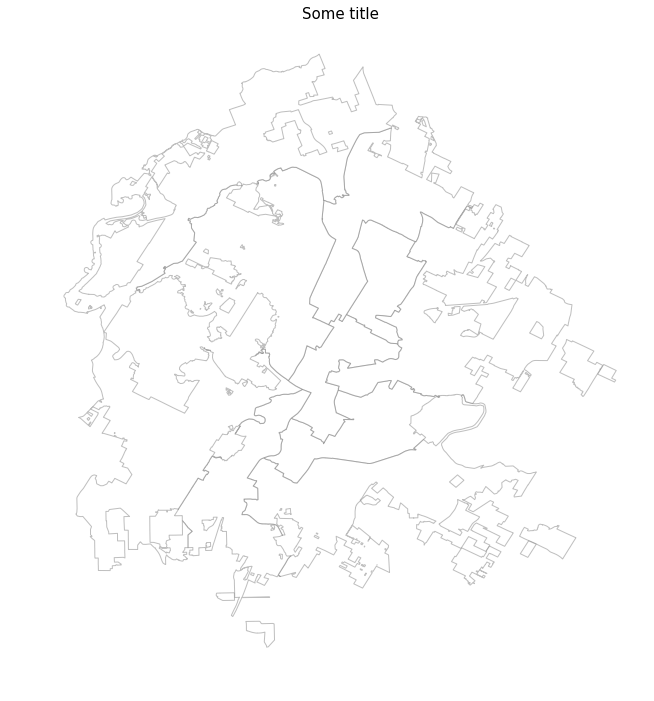

In [154]:
fig, ax = plt.subplots(figsize  = (12, 12))

ax.set_title("Some title", fontsize=15)

council_districts.plot(ax=ax, legend=True, scheme='Equal_Interval', k=5, color="white", edgecolor='grey', lw=1,alpha=0.5)

ax.axis('off')
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

dockless_sub_gdf[dockless_sub_gdf['hour']==16].plot(ax=ax, cmap='Reds', markersize=10)

#Correct aspect ratio
ax.axes.set_aspect('equal')

plt.show()

In [114]:
max(dockless.start_time)

Timestamp('2019-02-12 06:15:00')

In [115]:
min(dockless.start_time)

Timestamp('2018-04-03 18:30:00')

In [117]:
import time
a= time.time()

In [118]:
time.time() - a

7.398709058761597